In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
Base.metadata.create_all(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
latestdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latestdate)
print(latestdate.date)

('2017-08-23',)
2017-08-23


         ID      Station        Date  Precipitation  Temperature
0      2365  USC00519397  2016-08-24           0.08         79.0
1      2366  USC00519397  2016-08-25           0.08         80.0
2      2367  USC00519397  2016-08-26           0.00         79.0
3      2368  USC00519397  2016-08-27           0.00         77.0
4      2369  USC00519397  2016-08-28           0.01         78.0
...     ...          ...         ...            ...          ...
2218  19546  USC00516128  2017-08-19           0.09         71.0
2219  19547  USC00516128  2017-08-20            NaN         78.0
2220  19548  USC00516128  2017-08-21           0.56         76.0
2221  19549  USC00516128  2017-08-22           0.50         76.0
2222  19550  USC00516128  2017-08-23           0.45         76.0

[2223 rows x 5 columns]


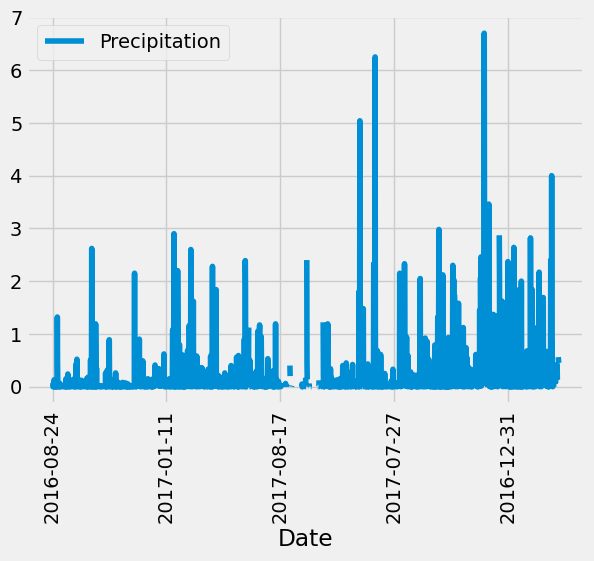

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
yearago = dt.datetime.strptime(latestdate.date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
one_year_data = session.query(Measurement).filter(Measurement.date >= yearago)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
one_year_df = pd.read_sql(one_year_data.statement, one_year_data.session.bind) # From https://stackoverflow.com/questions/12047193/how-to-convert-sql-query-result-to-pandas-data-structure
one_year_df.rename(columns={'id':'ID','station':'Station','date':'Date','prcp':'Precipitation','tobs':'Temperature'},inplace=True)
# Sort the dataframe by date
one_year_df.sort_values(by='Date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
print(one_year_df)
one_year_df.plot(x='Date',y='Precipitation')
plt.xticks(rotation = 90)
plt.show()

# I can't figure out why in the world it's putting the dates on the line graph out of order. I'm just going to have to move on before my head explodes XD

In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_df = pd.DataFrame(one_year_df['Precipitation'].describe())
summary_df

# Is there a particular reason the original notebook had this in a dataframe rather than an ordinary output?

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number of stations in the dataset
print(session.query(Station.station).distinct().count())
print(session.query(Measurement.station).distinct().count()) # Both ways just to check...

9
9


In [41]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

<Axes: xlabel='Temperature (F)', ylabel='Occurences'>

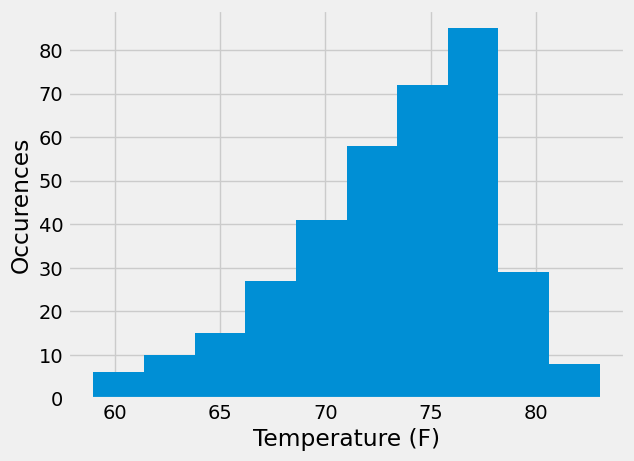

In [55]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
selection = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= yearago)
temps_df = pd.DataFrame(selection.all())
temps_df.plot(kind='hist',legend=False,xlabel='Temperature (F)',ylabel='Occurences')

# Close Session

In [16]:
# Close Session
session.close()